In [2]:
%matplotlib inline
import pylab
import nengo
import numpy as np

In [8]:
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: (np.sin(t*np.pi*2),0))
    a = nengo.Ensemble(100, 2, seed=2)
    b = nengo.Ensemble(101, 2, seed=3)
    
    nengo.Connection(stim, a)
    conn = nengo.Connection(a, b)
    
    p = nengo.Probe(b, synapse=0.03)
    p_stim = nengo.Probe(stim, synapse=0.03)

    
def parisien_transform(conn, model, inh_synapse, inh_proportion=0.25):
    # only works for ens->ens connections
    assert isinstance(conn.pre_obj, nengo.Ensemble)
    assert isinstance(conn.post_obj, nengo.Ensemble)    
    
    # make sure the pre and post ensembles have seeds so we can guarantee their params
    if conn.pre_obj.seed is None:
        conn.pre_obj.seed = np.random.randint(0x7FFFFFFF)
    if conn.post_obj.seed is None:
        conn.post_obj.seed = np.random.randint(0x7FFFFFFF)
        
    # compute the encoders, decoders, and tuning curves
    model2 = nengo.Network(add_to_container=False)
    model2.ensembles.append(conn.pre_obj)
    model2.ensembles.append(conn.post_obj)
    model2.connections.append(conn)
    sim = nengo.Simulator(model2)
    enc = sim.data[conn.post_obj].encoders
    dec = sim.data[conn].weights
    eval_points = sim.data[conn].eval_points
    pts, act = nengo.utils.ensemble.tuning_curves(conn.pre_obj, sim, inputs=eval_points)
    print pts.shape
    
    # compute the original weights
    transform = nengo.utils.builder.full_transform(conn)
    w = np.dot(enc, np.dot(transform, dec))
    
    # compute the bias function, bias encoders, bias decoders, and bias weights
    total = np.sum(act, axis=1)    
    bias_d = np.ones(conn.pre_obj.n_neurons) / np.max(total)    
    bias_func = total / np.max(total)    
    bias_e = np.max(-w / bias_d, axis=1)
    bias_w = np.outer(bias_e, bias_d)
    
    print np.min(w + bias_w)
    print np.max(w + bias_w)
    
    # add the new model compontents
    with model:
        nengo.Connection(conn.pre_obj.neurons, conn.post_obj.neurons,
                         transform=bias_w,
                         synapse=conn.synapse)

        inh = nengo.Ensemble(n_neurons = int(conn.pre_obj.n_neurons*inh_proportion),
                             dimensions = 1,
                             encoders = nengo.dists.Choice([[1]]),
                             intercepts= nengo.dists.Uniform(0, 1))

        nengo.Connection(conn.pre_obj, inh, 
                         solver=nengo.solvers.NnlsL2(),
                         transform=1,
                         synapse=inh_synapse,
                         **nengo.utils.connection.target_function(pts, bias_func))

        nengo.Connection(inh, conn.post_obj.neurons,
                         solver=nengo.solvers.NnlsL2(),
                         transform=-bias_e[:,None])
    
        

parisien_transform(conn, model, inh_synapse=conn.synapse) 
    


(1000, 2)
-2.71050543121e-20
0.000404459868232


In [9]:
sim = nengo.Simulator(model)
sim.run(2)

Simulation finished in 0:00:03.                                                 


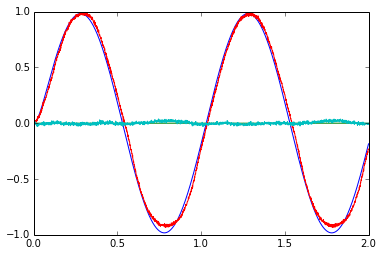

In [10]:
pylab.plot(sim.trange(), sim.data[p_stim])
pylab.plot(sim.trange(), sim.data[p])
pylab.show()